# Exercise 1
## 1 Loading the Dataset

In [263]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold
import warnings
warnings.filterwarnings('ignore')

In [264]:
#load dataset
digits = load_digits ()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

#data filtering 
num_1, num_2 = 3, 8
mask = np.logical_or(target == num_1, target == num_2)
data = data[mask]
target = target[mask]

#add column of 1's
data = np.hstack((data,np.ones((len(data),1))))

#relabel targets
target[target == num_1] = 1
target[target == num_2] = -1

### 1.1 Classification with sklearn

In [265]:
def hyperpar(lambdaSpace,k_splits=20):
    #grid search
    means=[]
    for i in range(len(lambdaSpace)):
        kf = KFold(n_splits=k_splits)
        kf.get_n_splits(data)
        scores=[]
        for train_index, test_index in kf.split(data):
            logReg=LogisticRegression(C=lambdaSpace[i],solver='lbfgs')
            logReg.fit(data[train_index],target[train_index])
            scores.append(logReg.score(data[test_index],target[test_index]))
        means.append(np.mean(scores))
    return means

In [266]:
lam=np.logspace(-2,5,8)
hyperpar(lam)

[0.9859477124183007,
 0.9915032679738562,
 0.9942810457516339,
 0.9942810457516339,
 0.9942810457516339,
 0.9942810457516339,
 0.9942810457516339,
 0.9972222222222221]

Since the means are all similar or even equal we choose $\lambda=100$

### 1.2 Optimization Methods

In [267]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def gradient(beta,X,y,lam=100):
    if len(X.shape)>1:
        return beta-lam/len(X)*np.sum(np.multiply(sigmoid(-np.multiply(y,X@beta)),np.multiply(y,X.T)),axis=1)
    else:
        return beta-lam*sigmoid(-y*X@beta)*y*X.T
    
def predict(beta,X):
    return np.sign(X@beta)

def zero_one_loss(y_pred,y_truth):
    return np.count_nonzero(y_pred!=y_truth)

In [268]:
#dummy data
#N=4,d=3
y=np.array([1,1,-1,1])
X=np.random.randint(0,5,size=(4,3))
b=np.random.randint(1,5,3)
X,y,b

(array([[0, 0, 4],
        [0, 0, 3],
        [1, 1, 0],
        [3, 1, 4]]), array([ 1,  1, -1,  1]), array([1, 4, 4]))

In [269]:
def gradient_decent(m, X, y, tau=.1, gamma=.01,beta=0, lam = 100):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    for iteration in range(m):
        beta = beta - tau/(1 + gamma*iteration) * gradient(beta,X,y)
    return beta

def SG(m, X, y, tau=.1, gamma=.01,beta=0, lam = 100):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    for iteration in range(m):
        instance = np.random.randint(N)
        beta = beta - tau/(1 + gamma*iteration) * gradient(beta,X[instance],y[instance])
    return beta

def SG_minibatch(m, X, y, tau=.1, gamma=.01,batchsize=16,beta=0, lam = 100):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    indices = np.arange(len(X))
    for iteration in range(m):
        instances = np.random.permutation(len(X))[:batchsize]
        beta = beta - tau/(1 + gamma*iteration) * gradient(beta,X[instances],y[instances])
    return beta

def SG_momentum(m,X,y,tau=.1,gamma=.01,mu=.5,beta=0,lam=100):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    g=np.zeros(d)
    for t in range(m):
        #choose random instance
        i = np.random.randint(N)
        g=mu*g+(1-mu)*gradient(beta,X[i],y[i])
        beta=beta-tau/(1+gamma*t)*g
    return beta

def ADAM(m,X,y,tau=1e-4,epsilon=1e-8,mu1=.9,mu2=.999,beta=0,lam=100):
    #initialize with 0 see original paper
    #(https://arxiv.org/pdf/1412.6980.pdf)
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    g=q=np.zeros(d)
    for t in range(m):
        #without replacement
        index=np.random.randint(len(X))
        l=gradient(beta,X[index],y[index])
        g=(1-mu1)*l+mu1*g
        q=(1-mu2)*np.square(l)+mu2*q
        g_til=np.divide(g,1-mu1)
        q_til=np.divide(q,1-mu2)
        beta=beta-tau*np.divide(g_til,np.sqrt(q)+epsilon)
    return beta

def stochastic_average_gradient(m,X,y,tau_0=.1,gamma=.01,beta=0,lam=100):
    #initialization
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    g_stored=-np.multiply(np.multiply(sigmoid(-np.multiply(y,X@beta)),y),X.T)
    g=np.sum(g_stored,axis=1)/N
    for t in range(m):
        i=np.random.randint(N)
        g_i=-y[i]*np.multiply(X[i].T,sigmoid(-y[i]*X[i]@beta))
        g=g+(g_i-g_stored.T[i])/N
        g_stored.T[i]=g_i
        tau_t=tau_0/(1+gamma*t)
        beta=beta*(1-tau_t/lam)-tau_t*g
    return beta

def dual_coordinate_ascent(m,X,y,beta=0,lam=100,epsilon=1e-8):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    alpha=np.random.uniform(size=N)
    beta = lam/N * np.sum(np.multiply(np.multiply(alpha,y),X.T),axis = 1)
    for t in range(m):
        i=np.random.randint(N)
        f_p=y[i]*X[i]@beta+np.log(alpha[i]/(1-alpha[i]))
        f_pp=lam/N*X[i]@X[i].T+1/(alpha[i]*(1-alpha[i]))
        next_alpha_i=np.clip(alpha[i]-f_p/f_pp,a_max=1-epsilon,a_min=epsilon)
        beta=beta+lam/N*y[i]*X[i].T*(next_alpha_i-alpha[i])
        alpha[i]=next_alpha_i
    return beta

def newton(m,X,y,beta=0,lam=100):
    N,d=X.shape
    if type(beta)!=np.ndarray:
        beta=np.zeros(d) if beta==0 else np.array(beta)
    z,y_weighted,W=None,None,None
    for t in range(m):
        z=X@beta
        y_weighted=np.divide(y,sigmoid(y*z))
        W=np.diag(lam/N*np.multiply(sigmoid(z),sigmoid(-z)))
        beta=LA.inv(np.identity(d)+X.T@W@X)@X.T@W@(z+y_weighted)
    return beta

### 1.3 Comparison

In [270]:
X,X_test,y,y_test = train_test_split(data,target,test_size=0.3,random_state=0)

#### Learning Rate
Not all algorithms need all three hyper parameters
* gradient descent needs $\tau$ and $\gamma$
* stochastic gradient needs $\tau$ and $\gamma$
* SG minibatch needs $\tau$ and $\gamma$
* SG momentum needs $\tau$, $\gamma$ and $\mu$
* ADAM needs $\tau$ (and $\mu_1$ and $\mu_2$ but they stay fixed)
* stochastic average gradient needs $\tau$ and $\gamma$
* dual coordinate as needs nothing
* Newton nedds nothing

In [271]:
tau_space=np.logspace(-3,-1,3)
mu_space=[.1,.2,.5]
gamma_space=np.logspace(-4,-2,3)

In [272]:
def hyperSeach(func,spaces,m,X,y):
    '''
    func: Optimization method as function
    spaces: a list of all hyper parameter spaces to be checked
            needs to be in order: tau, gamma, mu (leave out what is not needed)
    m: number of iterations
    X: data
    y: targets
    
    returns tuple of the best found hyper parameter in spaces
    '''
    N=len(spaces)
    kf = KFold(n_splits=10)
    hyper_par=[None]*N
    best_error=np.inf
    #perform exhaustive grid search
    for hyper in zip(*spaces):
        error=0
        for train_index ,validation_index in kf.split(X):
            X_train ,X_validation = X[train_index],X[validation_index]
            y_train ,y_validation = y[train_index],y[validation_index]
            #optimize
            beta=func(m,X_train,y_train,*list(hyper))
            error+=zero_one_loss(y,np.sign(X@beta))
        if error<best_error:
            hyper_par=list(hyper)
    return tuple(hyper_par)

In [273]:
#gradient descent
t,g=hyperSeach(gradient_decent,[tau_space,gamma_space],10,data,target)
print('parameters with lowest error rate: tau=%.2f, gamma=%.2f'%(t,g))

parameters with lowest error rate: tau=0.10, gamma=0.01


In [274]:
#SG
t,g=hyperSeach(SG,[tau_space,gamma_space],150,data,target)
print('parameters with lowest error rate: tau=%.2f, gamma=%.2f'%(t,g))

parameters with lowest error rate: tau=0.10, gamma=0.01


In [275]:
#SG minibatch
t,g=hyperSeach(SG_minibatch,[tau_space,gamma_space],150,data,target)
print('parameters with lowest error rate: tau=%.2f, gamma=%.2f'%(t,g))

parameters with lowest error rate: tau=0.10, gamma=0.01


In [276]:
#SG momentum
t,g,m=hyperSeach(SG_momentum,[tau_space,gamma_space,mu_space],150,data,target)
print('parameters with lowest error rate: tau=%.2f, gamma=%.2f, mu=%.2f'%(t,g,m))

parameters with lowest error rate: tau=0.10, gamma=0.01, mu=0.50


In [277]:
#ADAM
t=hyperSeach(ADAM,[tau_space],150,data,target)
print('parameters with lowest error rate: tau=%.2f'%t)

parameters with lowest error rate: tau=0.10


In [278]:
#stochastic average gradient 
t,g=hyperSeach(ADAM,[tau_space,gamma_space],150,data,target)
print('parameters with lowest error rate: tau=%.2f, gamma=%.2f'%(t,g))

parameters with lowest error rate: tau=0.10, gamma=0.01


#### Speed

In [283]:
functions = [gradient_decent,SG,SG_minibatch,SG_momentum,ADAM,stochastic_average_gradient,dual_coordinate_ascent,newton]
train_err = []
test_err = []
iterations = np.logspace(1,3.4,10,dtype=int)
for i in range(len(functions)):
    f_i,f_it=[],[]
    for m in iterations:
        function = functions[i]
        if i != 4 :  
            beta = function(m,X,y)
        f_i.append(zero_one_loss(predict(beta,X),y))
        f_it.append(zero_one_loss(predict(beta,X_test),y_test))
    train_err.append(f_i)
    test_err.append(f_it)

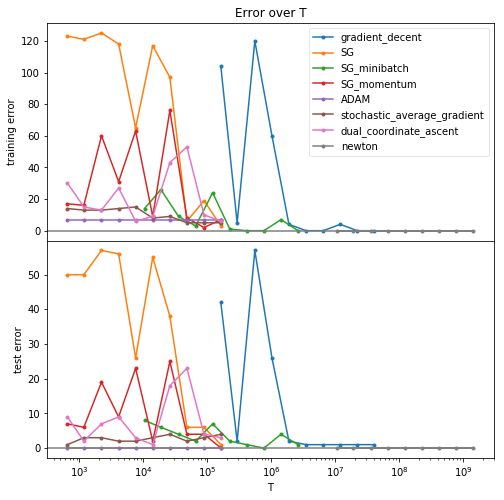

In [284]:
N,d = X.shape
B = 16
grad_time = N*d*iterations 
stoch_time = d*iterations
mini_time = B*d*iterations
newton_time = N*d**2*iterations
T = np.array([grad_time,stoch_time,mini_time,stoch_time,stoch_time,stoch_time,stoch_time,newton_time])
plt.figure(figsize=(8,8))
F=len(functions)
for i in range(F):
    plt.subplot(2, 1, 1)
    plt.semilogx(T[i], train_err[i], '.-',label=functions[i].__name__)
    plt.title('Error over T')
    plt.ylabel('training error')
    plt.legend(loc='best',framealpha=.5)
    plt.subplot(2, 1, 2)
    plt.subplots_adjust(hspace=0)
    plt.semilogx(T[i], test_err[i], '.-',label=functions[i].__name__)    
    plt.xlabel('T')
    plt.ylabel('test error')

The best (lowest error after complete traing) concergence is reached by newton, stochastic average decent, gradient decent and minibatch.The other algorithms (exept ADAM) tend to fluctuate a lot. ADAM reaches its lowest error after the first iteration and stays constant (at a rather low value). The fastest to konverge seems to be stochastic average gradient. Remarkable is that the newton algorithm always reaches the lowest test error but also is very slow.